<a href="https://colab.research.google.com/github/haedal-uni/analysis/blob/main/work/2025-04/Robo-Advisor/%EB%8B%A8%EC%88%9C%20%EC%9D%B4%EB%8F%99%ED%8F%89%EA%B7%A0%20%EC%A0%84%EB%9E%B5%20%2B%20%EC%8B%9C%EA%B0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 단순한 이동평균 전략 (SMA)을 사용

- 종목별 전략 수익률을 시각화

- 포트폴리오 개념 없이 각 종목을 독립적으로 평가

- 전략 적용은 개별 종목 기준

<br>

[링크](
https://github.com/ald0met/RoboAdvisor_with_Python/blob/main/market_timing_module1.ipynb)에 있는 코드를 참고함

In [2]:
import warnings
import matplotlib
import sys
import numpy as np
import os
import pandas as pd
warnings.filterwarnings(action='ignore')
if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections
    # 나눔 폰트를 설치
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)
matplotlib.rcParams['font.family'] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum.
(Reading database ... 126315 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


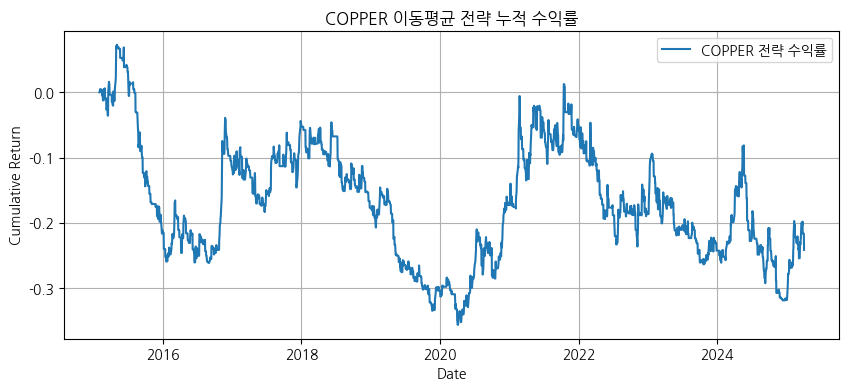

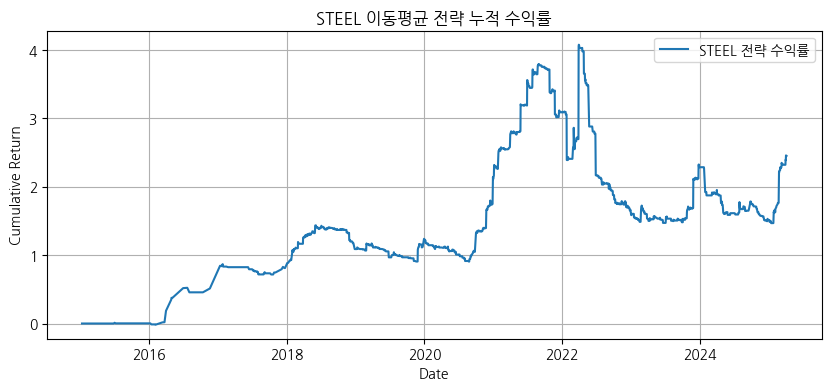

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
df1 = pd.read_csv('미국 철강 코일 선물 과거 데이터.csv', parse_dates=['날짜'], thousands=",")
df2 = pd.read_csv('구리 선물 과거 데이터.csv', parse_dates=['날짜'], thousands=",")

# 2. 전처리
for df in [df1, df2]:
    df['거래량'] = df['거래량'].apply(lambda x: float(str(x).replace('K', '')) * 1000 if 'K' in str(x) else float(x))
    df['변동 %'] = df['변동 %'].apply(lambda x: float(str(x).replace('%', '')) / 100)
    df.sort_values('날짜', inplace=True)
    df.dropna(inplace=True)

# 3. 종목 코드 추가 (ticker 역할)
df1['ticker'] = 'STEEL'
df2['ticker'] = 'COPPER'

# 4. 데이터 통합
data = pd.concat([df1, df2], ignore_index=True)
data.rename(columns={'날짜': 'date', '종가': 'close'}, inplace=True)

# 5. 이동평균 전략
def apply_moving_average(df, period=3):
    df = df.copy()
    df['ma'] = df['close'].rolling(window=period).mean()
    df['position'] = (df['close'] > df['ma']).astype(int)  # 1 = 매수 상태
    df['daily_return'] = df['close'].pct_change()
    df['strategy_return'] = df['daily_return'] * df['position'].shift(1)
    df['cumulative_return'] = (1 + df['strategy_return']).cumprod() - 1
    return df

# 6. 결과 계산 및 시각화
results = []
for ticker, group in data.groupby('ticker'):
    result = apply_moving_average(group)
    result['ticker'] = ticker
    results.append(result)

final_df = pd.concat(results)

# 7. 시각화
for ticker in final_df['ticker'].unique():
    df_plot = final_df[final_df['ticker'] == ticker]
    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['cumulative_return'], label=f'{ticker} 전략 수익률')
    plt.title(f'{ticker} 이동평균 전략 누적 수익률')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid()
    plt.show()
